In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Inspect the columns in each table
measurementColumns = inspector.get_columns('measurement')
for column in measurementColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
stationColumns = inspector.get_columns('station')
for column in stationColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Find the most recent date in the data set.
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all():
    print(row)
# Ordered by date, the most recent date is 2017-08-23

('2017-08-23',)


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
precipData = []

# Calculate the date one year from the last date in data set.
oneyear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(oneyear)

# Perform a query to retrieve the data and precipitation scores, sort by date
for row in session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all():
    precipData.append(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf = pd.DataFrame(precipData, columns=['Date','Precipitation'])

# Instructions say to set index to the date, but this is not ideal for building charts. Copy the below code if index later needs to be set to the Date.
    # precipdf = precipdf.set_index('Date')


2016-08-23


In [16]:
# Drop NaN rows
precipdf.dropna(how="any", inplace=True)
precipdf

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
4,2016-08-24,1.22
5,2016-08-24,2.15
...,...,...
2218,2017-08-22,0.50
2219,2017-08-23,0.00
2220,2017-08-23,0.00
2221,2017-08-23,0.08


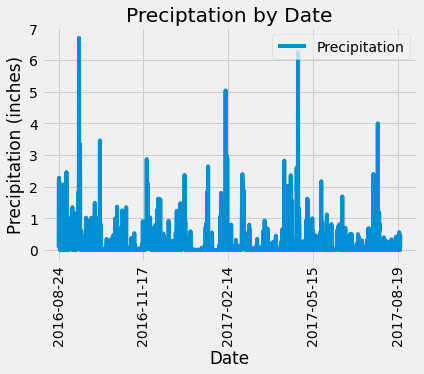

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data

precipdf.plot(x="Date",y="Precipitation",rot = 90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Preciptation by Date")
plt.legend(loc="upper right")
plt.show()

In [22]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipdf.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
stations = session.execute('SELECT DISTINCT station from station').fetchall()
len(stations)


9

In [29]:
# Quick sanity check to ensure there are no stations with measurement recordings that don't exist in the table of stations
stations2 = session.execute('SELECT DISTINCT station from measurement').fetchall()
print(stations2)

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [31]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

stationData = []
for row in session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all():
    stationData.append(row)
stationdf = pd.DataFrame(stationData, columns=['ID','Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
stationdf

measureData = []
for row in session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).order_by(Measurement.date).all():
    measureData.append(row)
measuredf = pd.DataFrame(measureData, columns=['ID','Station', 'Date', 'Precip', 'TOBs'])



,ID,Station,Name,Latitude,Longitude,Elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [32]:
# List the stations and the counts in descending order.
measuredf['Station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()